# Hough transform in 3D 

In [65]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from itertools import product

## Generate weird data

In [66]:
x = np.random.uniform(low=-500, high=500, size=100)
y = np.random.uniform(low=-500, high=500, size=100)
z = np.random.uniform(low=-500, high=500, size=100)

points = np.array(list(zip(x, y, z)))

### Show the points

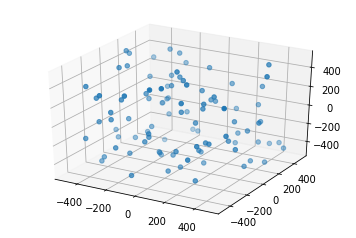

In [67]:
point_cloud = plt.axes(projection='3d')
point_cloud.scatter3D(x, y, z)

## Implementation of the Hough transform in 3D

### Algorithm

In [68]:
class GeoTransformations:
    """
    Helpful analytical operations in
    cartesian and spherical coordinates
    """
    
    def spherical_coord_to_cartesian_coord(self,
                                           point: np.array) -> np.array:
        """
        Convert a point in spherical coordinates
        to a point in euclid coordinates
        """
        
        r, theta_1, theta_2 = point
        
        # Cartesian coordinates
        x = np.sin(theta_1) * np.cos(theta_2)
        y = np.sin(theta_1) * np.sin(theta_2)
        z = np.cos(theta_1)
        
        return r * np.array([x, y, z])
    
    def euclid_point_to_plane(self, point: np.ndarray,
                                plane: np.ndarray) -> float:
        """
        Calculate euclid dist between a point
        and a plane, both in euclid coordinates
        
        plane: np.array([a, b, c, d]) such that
        ax + by + cz + d = 0
        
        point: np.array([x, y, z])
        """
        
        numerator = abs(np.sum(np.multiply(plane[:-1], point)) + plane[-1])
        denominator = np.sqrt(np.sum(plane[:-1]**2))
        
        return numerator / denominator
    
    def max_dist_point(self, points: np.ndarray) -> float:
        """
        Find the point with the maximum distance
        from the origin
        """
        
        distances = np.array([np.sqrt(np.sum(point**2))
                              for point in points])
        
        return np.max(distances)

In [69]:
class Hough3D(GeoTransformations):
    
    def __init__(self, point_cloud: np.ndarray, dist_to_plane: float = 5.,
                 threshold: int = 10, r_diff: float = 5.,
                 theta_1: float = np.pi / 10, theta_2: float = np.pi / 10):
        super().__init__()
        self.points = point_cloud
        self.dist = dist_to_plane
        self.threshold = threshold
        self.r_diff = r_diff
        self.theta_1 = theta_1
        self.theta_2 = theta_2
        
        # Limit the searching to a sphere
        self.r_of_space = self.max_dist_point(points)
        
        # Calculate number of steps on each axis
        self.r_dim = int(np.ceil(self.r_of_space / r_diff)) + 1
        self.theta_1_dim = int(np.ceil(2*np.pi / theta_1)) + 1
        self.theta_2_dim = int(np.ceil(2*np.pi / theta_2)) + 1
        
    def spherical_ind_to_coords(self, point: np.ndarray) -> np.ndarray:
        """
        Each index in the spherical coordinates
        refers to the real value in the spherical coordinates
        """
        
        factor = np.array([self.r_diff, self.theta_1, self.theta_2])
        
        real_point = np.multiply(factor, point)
        
        return real_point
    
    def all_possible_planes(self) -> np.ndarray:
        """
        Find all possible planes, each coresponding
        to the unique (r, theta1, theta2) tuple
        """
        
        # All possible planes
        r_coord = np.linspace(-self.r_of_space, self.r_of_space, self.r_dim)
        theta_1_coord = np.linspace(0, 2*np.pi, self.theta_1_dim)
        theta_2_coord = np.linspace(0, 2*np.pi, self.theta_2_dim)
        planes = np.array(list(product(r_coord, theta_1_coord, theta_2_coord)))
        
        return planes
    
    def voting_phase(self) -> np.ndarray:
        """
        Find points in spherical coordinates coresponding to
        the expected planes
        """
        
        # All possible planes
        planes = self.all_possible_planes()
        
        # Declare the matrix of results
        votes = np.zeros(planes.shape[0])
        
        for index, plane in enumerate(planes):
            real_plane_coords = self.spherical_ind_to_coords(plane)
            
            euclid_plane_coord = \
                self.spherical_coord_to_cartesian_coord(real_plane_coords)
            
            # Find orthogonal vector in euclid coord
            ort_vec = self.spherical_coord_to_cartesian_coord(plane)
            
            # d param of the plane
            d = -np.sum(ort_vec**2)
            
            # Final form of the plane in euclid coordinates (a, b, c, d)
            euclid_plane = np.append(ort_vec, [d])
            
            for point in self.points:
                if self.euclid_point_to_plane(point, euclid_plane) < self.dist:
                    votes[index] += 1
        
        # Convert 1d votes array to 3d votes array
        votes = votes.reshape(self.r_dim, self.theta_1_dim, self.theta_2_dim)
        
        return votes
    
    def plot_voting_phase(self, votes: np.ndarray) -> np.ndarray:
        """
        Plot the points coresponding to the found planes
        in spherical coordinates
        """
        
        pass
        
    def estimation_phase(self, votes: np.array) -> np.ndarray:
        """
        Transform the points from a votes array to
        the points in spherical coordinates
        and filter the ones exceeding the threshold
        """
        
        # Filter the planes
        possible_planes = np.argwhere(votes >= self.threshold)
        
        factor = np.array([self.r_diff, self.theta_1, self.theta_2])
        
        # Switch indices to the real values (e.g. if the first index
        # of a plane was k, it becomes k*r_diff as the first coordinate)
        possible_planes = np.multiply(factor, possible_planes)
        
        return possible_planes

### Tests

In [79]:
hough = Hough3D(points, threshold=7)

In [71]:
hough.max_dist_point(points)

751.3044380636935

#### Voting phase

In [72]:
votes = hough.voting_phase()
votes

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [73]:
# h.plot_voting_phase

#### Estimation phase

In [80]:
found_planes = hough.estimation_phase(votes)
found_planes

array([[285.        ,   2.51327412,   5.02654825],
       [285.        ,   3.76991118,   1.88495559],
       [345.        ,   1.25663706,   4.08407045],
       [345.        ,   5.02654825,   0.9424778 ],
       [410.        ,   1.88495559,   0.9424778 ],
       [410.        ,   4.39822972,   4.08407045],
       [470.        ,   0.62831853,   1.88495559],
       [470.        ,   5.65486678,   5.02654825]])